In [1]:
import os
import sys

# Set working directory
plant_clef_root = '/home/ffw/workspace/plantCLEF/'
os.chdir(plant_clef_root)

data_dir = os.path.join(plant_clef_root, 'data')

import numpy as np
import sklearn
import scipy
import scipy.misc
import time

import matplotlib.pyplot as plt
%matplotlib inline

from utilities import *
import mcl

# Add the scatnet implementation to the system path
scatnet_path = '/home/ffw/workspace/thesis_scatnet/'
if scatnet_path not in sys.path:
    sys.path.append(scatnet_path)

import scattconvnet



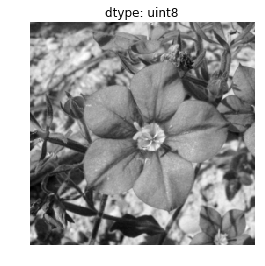

In [2]:
# configure plotting
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

if True:
    img = scipy.misc.imread('data/train/4013.jpg')[:600,:600,:]
    img = scipy.misc.imresize(img,size=(256,256))
    img = img[:,:,0]
else:
    img = np.ones((256,256), dtype='uint8') * 0

    for i in range(256):
        for j in range(256):
            if np.sqrt((i-128)**2 + (j-128)**2) < 80:
                img[i,j] = 180

    img[:,::40] = 255
    img[:,1::40] = 255
    img[:,2::40] = 255
    img[:,3::40] = 255
    img[:,4::40] = 255

    img[::84,:] = 255
    img[1::84,:] = 255
    img[2::84,:] = 255
    img[3::84,:] = 255
    img[4::84,:] = 255
    

plt.title("dtype: %s" % str(img.dtype))
plt.imshow(img[:,:]);
plt.axis('off');

In [3]:
import caffe
from caffe import layers as L
from caffe import params as P

In [4]:
use_gpu = True
if use_gpu:
    caffe.set_mode_gpu()
    caffe.set_device(0)
else:
    caffe.set_mode_cpu()

In [20]:
import mcl.nets.scatnet_net
reload(mcl.nets.scatnet_net)
from mcl.nets.scatnet_net import scatnet, gen_prototxt

scale = 3
scales = 2**np.arange(0,scale)
max_order = 3
nangles = 6

gen_prototxt(scales=scales, max_order=max_order, nangles=nangles, verbose=True);


scat1_0_1to6:
  kernel size: 8
  None->1 (6)
scat2_1_1to6:
  kernel size: 16
  None->2 (6)
scat4_2_1to6:
  kernel size: 32
  None->4 (6)
scat2_3_6to36:
  kernel size: 16
  None->1->2 (36)
scat4_4_6to36:
  kernel size: 32
  None->1->4 (36)
scat4_5_6to36:
  kernel size: 32
  None->2->4 (36)
scat4_6_36to216:
  kernel size: 32
  None->1->2->4 (216)
Total output dimensionality: 343


In [42]:
reload(mcl.nets.scatnet_net)

if 'net' in locals():
    del net
net = scatnet(scales=scales, max_order=max_order, nangles=nangles, filter_size_factor=8)

print('')
print("params:")
for k in net.params.keys():
    print "%s: %s" %(k,net.params[k][0].data.shape)
#print("\nBlobs")
#for k in net.blobs.keys():
#    print "%s: %s" %(k,net.blobs[k].data.shape)


params:
scat1_0_1to6_real: (6, 1, 8, 8)
scat1_0_1to6_imag: (6, 1, 8, 8)
scat2_3_6to36_real: (36, 1, 16, 16)
scat2_3_6to36_imag: (36, 1, 16, 16)
scat4_6_36to216_real: (216, 1, 32, 32)
scat4_6_36to216_imag: (216, 1, 32, 32)
scat2_1_1to6_real: (6, 1, 16, 16)
scat2_1_1to6_imag: (6, 1, 16, 16)
scat4_2_1to6_real: (6, 1, 32, 32)
scat4_2_1to6_imag: (6, 1, 32, 32)
scat4_4_6to36_real: (36, 1, 32, 32)
scat4_4_6to36_imag: (36, 1, 32, 32)
scat4_5_6to36_real: (36, 1, 32, 32)
scat4_5_6to36_imag: (36, 1, 32, 32)
psi: (343, 1, 32, 32)


In [43]:
img_input = img[np.newaxis, np.newaxis, :, :].copy()

for _ in range(0):
    img_input = np.append(img_input, img_input, 0)

net.blobs['data'].reshape(*img_input.shape)
net.blobs['data'].data[...] = img_input

In [44]:
%%time
caffe.set_mode_gpu()
caffe.set_device(0)
for _ in range(1):
    net.forward()
pass

CPU times: user 180 ms, sys: 48 ms, total: 228 ms
Wall time: 230 ms


In [45]:
output = np.squeeze(net.blobs['output'].data[0,:,:,:])


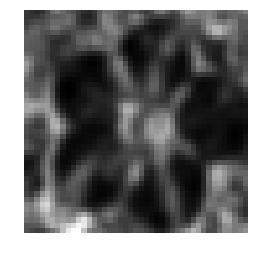

In [46]:
plt.imshow(np.squeeze(output[4,:,:]));
plt.axis('off');

In [47]:
def norm(tmp):    
    for l in range(tmp.shape[0]):
        mx = tmp[l].max()
        if mx == 0:
            continue
        if mx == np.inf:
            tmp[l] = 0
            continue
        tmp[l] /= mx
    return tmp


In [48]:
tmp = output[:,::,::,np.newaxis].copy()
print tmp.shape
tmp = np.concatenate([tmp,tmp,tmp],3)

(343, 43, 43, 1)


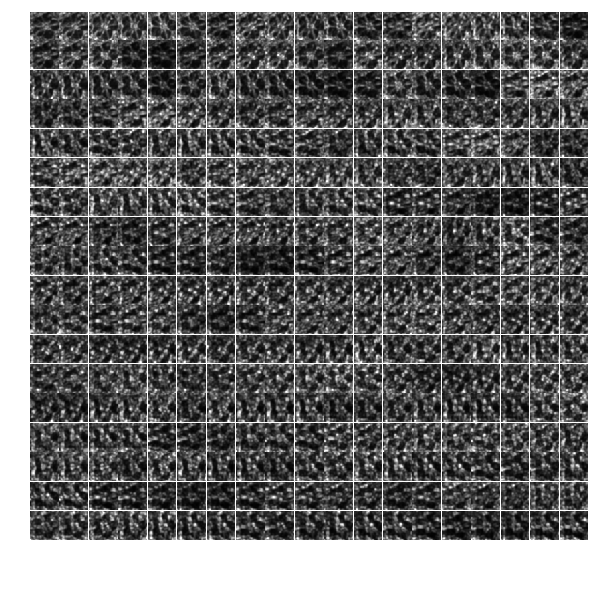

In [49]:
plt.figure(figsize=(10,10))
vis_square(norm(tmp[1:]))

# Old ScatNet

In [50]:
reload(scattconvnet.wavelet)
scatnet_old = scattconvnet.scatnet.ScatNet(nangles=nangles, max_order=max_order, scale=scale)

In [51]:
%%time
res_org = scatnet_old.process(img)

CPU times: user 4.83 s, sys: 0 ns, total: 4.83 s
Wall time: 4.82 s


In [52]:
res = res_org[:,11:-10,11:-10].copy()

(343, 43, 43, 1)


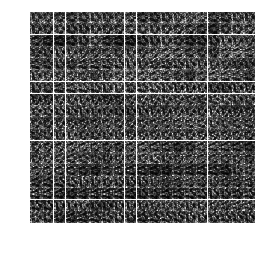

In [53]:
tmp = res[:,:,:,np.newaxis].copy()
print tmp.shape
tmp = np.concatenate([tmp,tmp,tmp],3)
vis_square(norm(tmp[1:]))

# Compare outputs

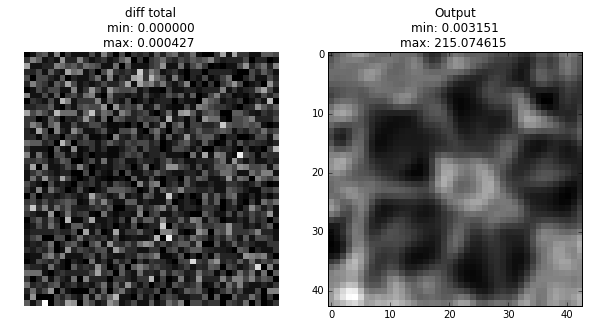

In [54]:
d_total = np.abs(np.sum(np.abs(output),0) - np.sum(np.abs(res),0))

plt.figure(figsize=(10,5))    
plt.subplot(1,2,1)
plt.title('diff total\nmin: %.6f\nmax: %.6f '% (d_total.min(), d_total.max()))
plt.imshow(d_total)
plt.axis('off');
plt.subplot(1,2,2)
plt.title('Output\nmin: %.6f\nmax: %.6f '% (output.min(), output.max()))
plt.imshow(np.sum(np.abs(output),0))
plt.show()

In [55]:
new_scat_out = np.sort(np.ravel(output))
new_scat_out /= new_scat_out.max()
old_scat_out = np.sort(np.ravel(res))
old_scat_out /= old_scat_out.max()

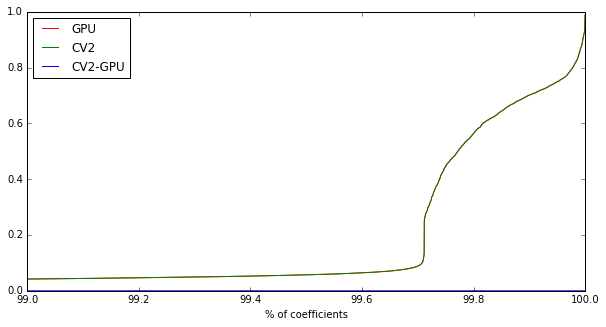

In [56]:
plt.figure(figsize=(10,5))
y = np.linspace(1,100,len(new_scat_out), endpoint=True)
mask = y>99
mask[::2] = False
plt.xlim([99,100])

p1, = plt.plot(y[mask],new_scat_out[mask],'r')
p2, = plt.plot(y[mask],old_scat_out[mask],'g')
p3, = plt.plot(y[mask],old_scat_out[mask]-new_scat_out[mask],'b')
#plt.xticks([])
plt.ylim([0,1]);
plt.xlabel('% of coefficients')
plt.legend([p1,p2,p3] , ['GPU','CV2','CV2-GPU'], loc='upper left');